 # EDA

In [2]:
# Load data
import pandas as pd

DATA_PATH = "../data/Mall_Customers.csv"
df = pd.read_csv(DATA_PATH)

# Normalize column names for easier access
df.columns = [c.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns]
df.head()

,customerid,gender,age,annual_income_k$,spending_score_1-100
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Dataset overview
print(df.shape)
df.info()

(200, 5)
<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   customerid            200 non-null    int64
 1   gender                200 non-null    str  
 2   age                   200 non-null    int64
 3   annual_income_k$      200 non-null    int64
 4   spending_score_1-100  200 non-null    int64
dtypes: int64(4), str(1)
memory usage: 7.9 KB


In [4]:
# Missing values and duplicates
print(df.isna().sum())
print(df.duplicated().sum())

customerid              0
gender                  0
age                     0
annual_income_k$        0
spending_score_1-100    0
dtype: int64
0


In [5]:
# Summary statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerid,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
annual_income_k$,200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
spending_score_1-100,200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


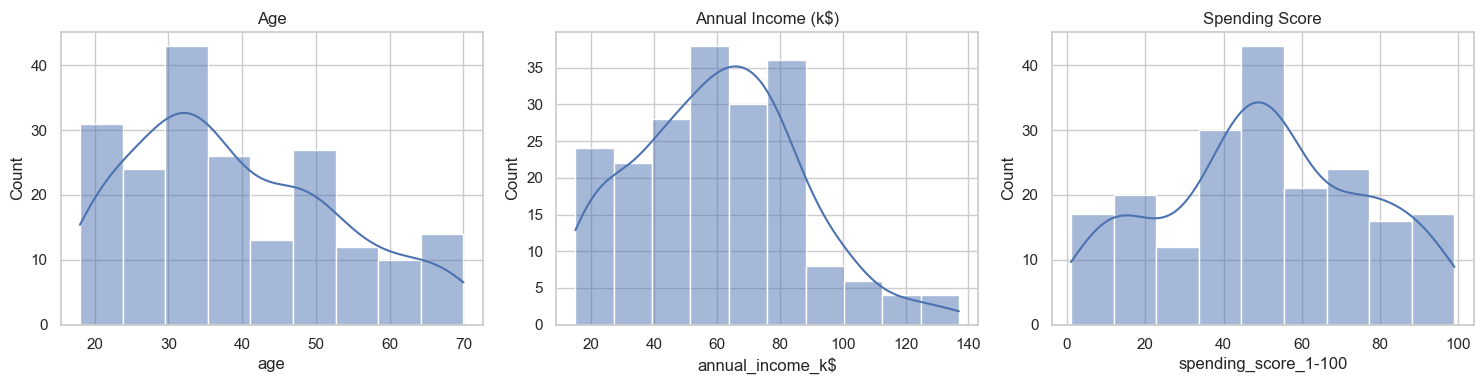

In [6]:
# Distributions
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df["age"], kde=True, ax=axes[0])
axes[0].set_title("Age")
sns.histplot(df["annual_income_k$"], kde=True, ax=axes[1])
axes[1].set_title("Annual Income (k$)")
sns.histplot(df["spending_score_1-100"], kde=True, ax=axes[2])
axes[2].set_title("Spending Score")
plt.tight_layout()

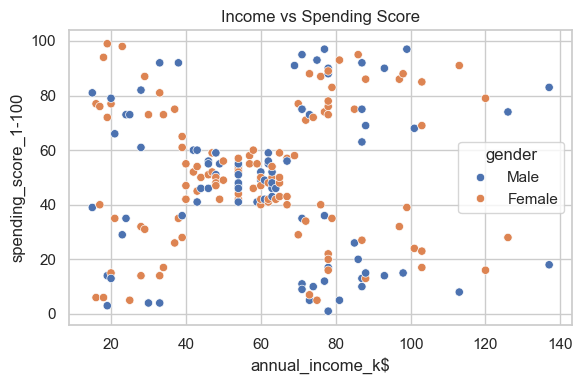

In [7]:
# Relationships
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="annual_income_k$", y="spending_score_1-100", hue="gender")
plt.title("Income vs Spending Score")
plt.tight_layout()

# KMeans

   customerid  age  annual_income_k$  spending_score_1-100  gender_Male
0           1   19                15                    39         True
1           2   21                15                    81         True
2           3   20                16                     6        False
3           4   23                16                    77        False
4           5   31                17                    40        False


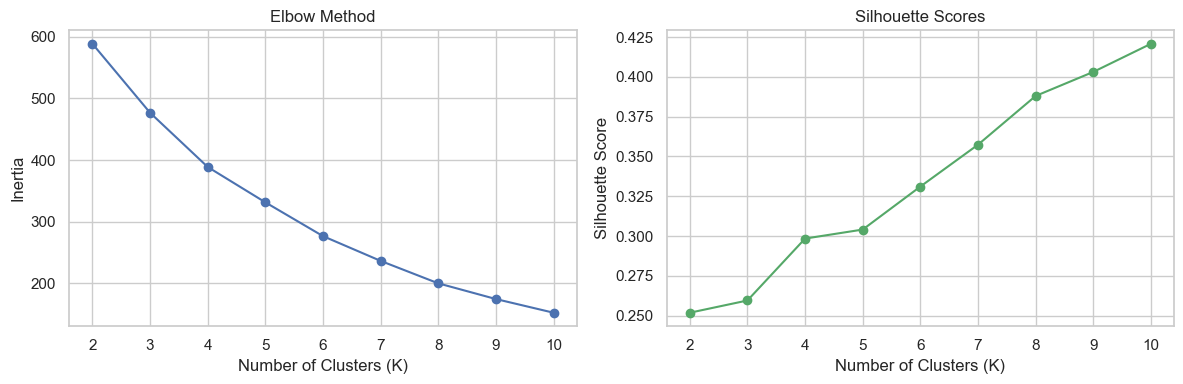

K=2: Inertia=588.80, Silhouette Score=0.2518
K=3: Inertia=476.79, Silhouette Score=0.2595
K=4: Inertia=388.72, Silhouette Score=0.2984
K=5: Inertia=331.31, Silhouette Score=0.3041
K=6: Inertia=276.41, Silhouette Score=0.3311
K=7: Inertia=236.20, Silhouette Score=0.3574
K=8: Inertia=199.75, Silhouette Score=0.3880
K=9: Inertia=174.24, Silhouette Score=0.4031
K=10: Inertia=152.03, Silhouette Score=0.4208


In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Prepare data for clustering

# one-hot encode gender
one_hot_encoded = pd.get_dummies(df, columns=["gender"], drop_first=True)
print(one_hot_encoded.head())


features = one_hot_encoded[["annual_income_k$", "spending_score_1-100", "gender_Male", "age"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method and silhouette scores
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Scores')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print scores
for k, inertia, sil_score in zip(k_range, inertias, silhouette_scores):
    print(f"K={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.4f}")

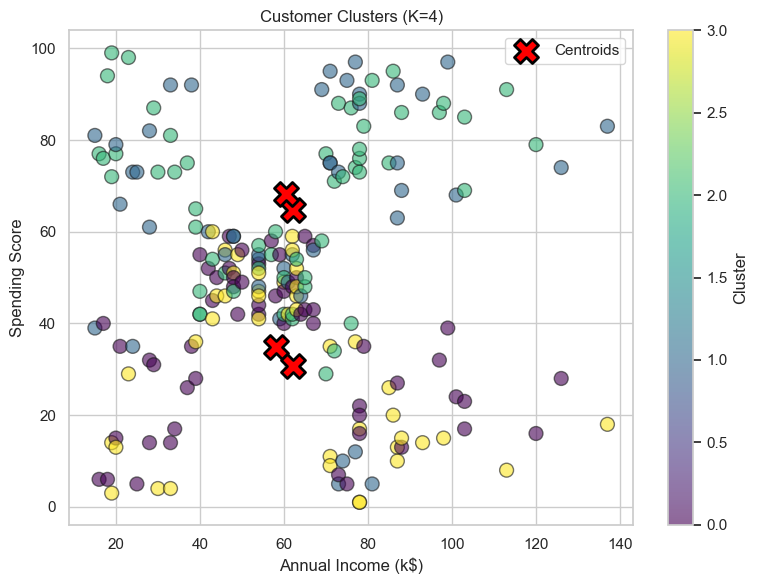

In [9]:
# Train KMeans
optimal_k = 4
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_optimal.fit(features_scaled)

# Copy data and add cluster labels to dataframe
df_copy = df.copy()
df_copy['cluster'] = kmeans_optimal.labels_

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_copy['annual_income_k$'], df_copy['spending_score_1-100'], 
                     c=df_copy['cluster'], cmap='viridis', s=100, alpha=0.6, edgecolors='k')
plt.scatter(scaler.inverse_transform(kmeans_optimal.cluster_centers_)[:, 0],
           scaler.inverse_transform(kmeans_optimal.cluster_centers_)[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.title(f'Customer Clusters (K={optimal_k})')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()

# Dimensionality Reduction

/Users/mpersson/COMP9130/week4/mini-project-3/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Explained variance ratio (PCA): [0.33690046 0.26230645]
Total explained variance (PCA): 0.5992069019819846


/Users/mpersson/COMP9130/week4/mini-project-3/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


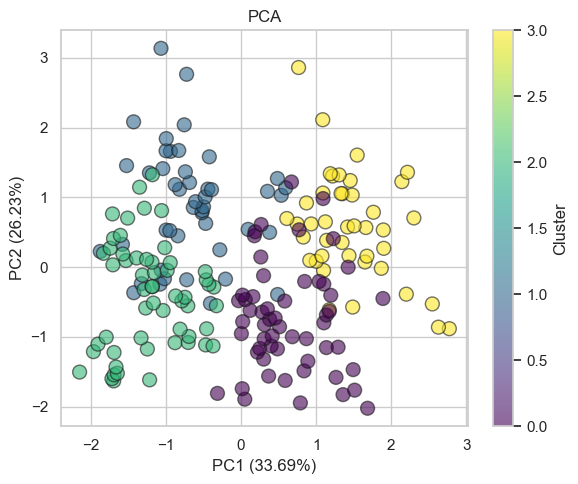

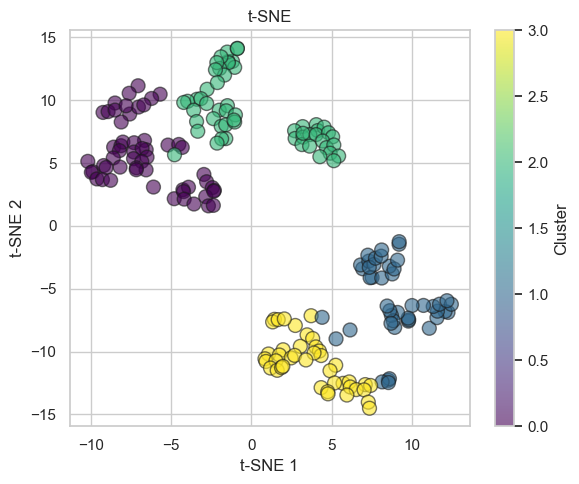

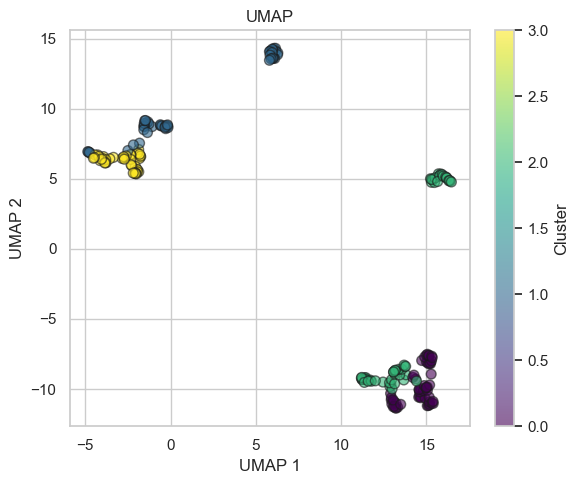

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Apply PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)
print("Total explained variance (PCA):", np.sum(pca.explained_variance_ratio_))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_scaled)

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_reducer.fit_transform(features_scaled)

# Visualize each embedding separately

# PCA
plt.figure(figsize=(6, 5))
scatter1 = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                       c=df_copy['cluster'], cmap='viridis', s=100, alpha=0.6, edgecolors='k')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA')
plt.colorbar(scatter1, label='Cluster')
plt.tight_layout()
plt.show()

# t-SNE
plt.figure(figsize=(6, 5))
scatter2 = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                       c=df_copy['cluster'], cmap='viridis', s=100, alpha=0.6, edgecolors='k')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE')
plt.colorbar(scatter2, label='Cluster')
plt.tight_layout()
plt.show()

# UMAP
plt.figure(figsize=(6, 5))
scatter3 = plt.scatter(features_umap[:, 0], features_umap[:, 1], 
                       c=df_copy['cluster'], cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP')
plt.colorbar(scatter3, label='Cluster')
plt.tight_layout()
plt.show()

               age                    annual_income_k$                      \
              mean        std min max             mean        std min  max   
cluster                                                                      
0        47.803571  10.011665  20  68        58.071429  26.140778  16  126   
1        28.000000   7.192589  18  40        62.239130  28.056439  15  137   
2        28.392857   5.532314  18  40        60.428571  26.064854  16  120   
3        52.738095  11.238131  32  70        62.214286  25.333421  19  137   

        spending_score_1-100                    gender               
                        mean        std min max   mean  std min max  
cluster                                                              
0                  34.875000  16.329630   5  59    0.0  0.0   0   0  
1                  64.826087  24.457041   5  97    1.0  0.0   1   1  
2                  68.178571  18.502194  29  99    0.0  0.0   0   0  
3                  30.642857  19.

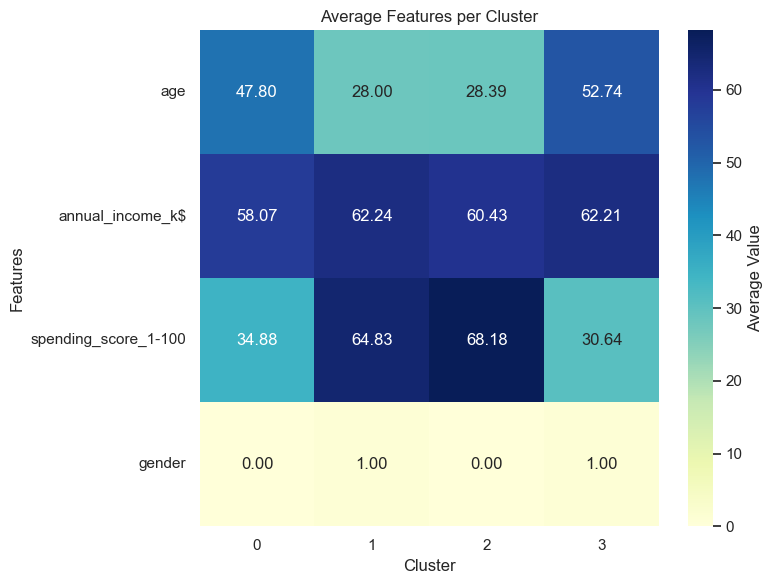

In [11]:
# Convert gender to numeric for aggregation
df_copy['gender'] = (df_copy['gender'] == 'Male').astype(int)

# Summarize features per cluster
cluster_summary = df_copy.groupby('cluster')[['age', 'annual_income_k$', 'spending_score_1-100', 'gender']].agg(['mean', 'std', 'min', 'max'])
print(cluster_summary)

# Count customers per cluster
cluster_counts = df_copy['cluster'].value_counts().sort_index()
print("\nCustomers per cluster:")
print(cluster_counts)
# Heatmap of cluster averages
cluster_means = df_copy.groupby('cluster')[['age', 'annual_income_k$', 'spending_score_1-100', 'gender']].mean()
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Average Value'})
plt.title('Average Features per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# Anomaly Detection

Contamination: 0.05
  Anomalies detected: 10
  Normal points: 190

Contamination: 0.1
  Anomalies detected: 20
  Normal points: 180

Contamination: 0.15
  Anomalies detected: 30
  Normal points: 170



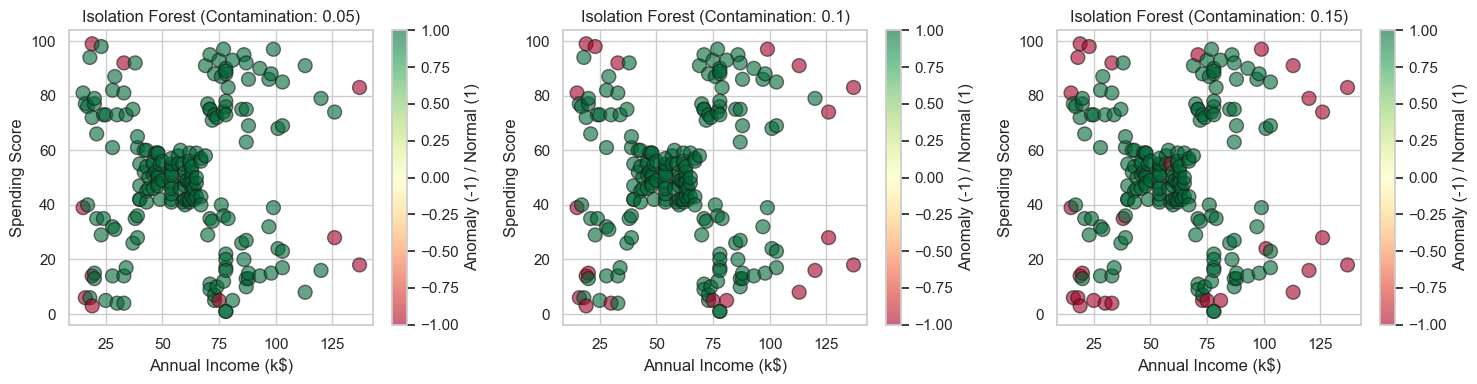

In [12]:
from sklearn.ensemble import IsolationForest

# Test with 3 different contamination values
contamination_values = [0.05, 0.1, 0.15]
anomaly_results = {}

for contamination in contamination_values:
    # Train Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomaly_labels = iso_forest.fit_predict(features_scaled)
    
    # -1 indicates anomalies, 1 indicates normal points
    n_anomalies = (anomaly_labels == -1).sum()
    
    anomaly_results[contamination] = {
        'model': iso_forest,
        'labels': anomaly_labels,
        'n_anomalies': n_anomalies
    }
    
    print(f"Contamination: {contamination}")
    print(f"  Anomalies detected: {n_anomalies}")
    print(f"  Normal points: {(anomaly_labels == 1).sum()}")
    print()

# Visualize anomalies for each contamination value
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, contamination in enumerate(contamination_values):
    anomaly_labels = anomaly_results[contamination]['labels']
    
    scatter = axes[idx].scatter(df_copy['annual_income_k$'], df_copy['spending_score_1-100'],
                                c=anomaly_labels, cmap='RdYlGn', s=100, alpha=0.6, edgecolors='k')
    axes[idx].set_xlabel('Annual Income (k$)')
    axes[idx].set_ylabel('Spending Score')
    axes[idx].set_title(f'Isolation Forest (Contamination: {contamination})')
    plt.colorbar(scatter, ax=axes[idx], label='Anomaly (-1) / Normal (1)')

plt.tight_layout()
plt.show()

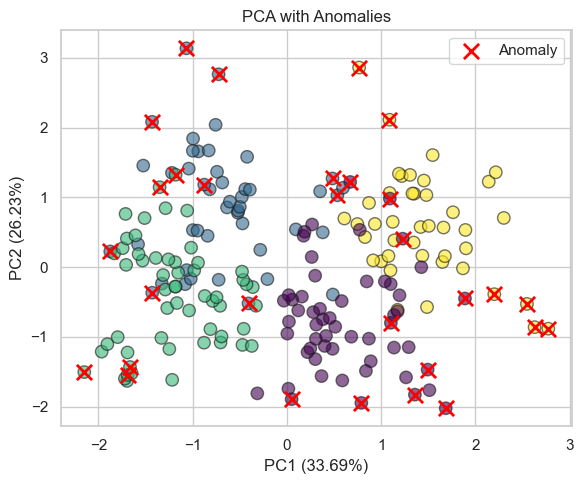

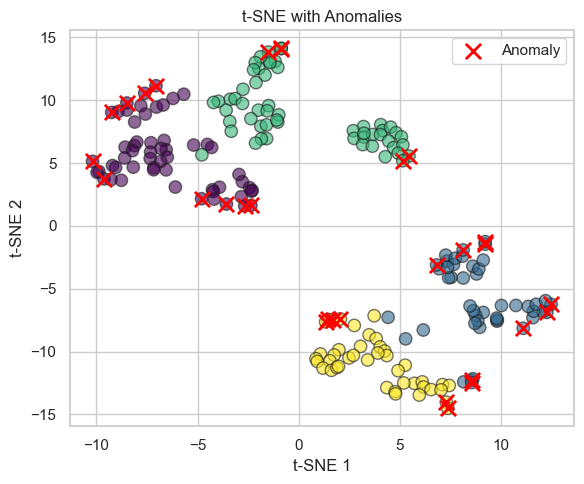

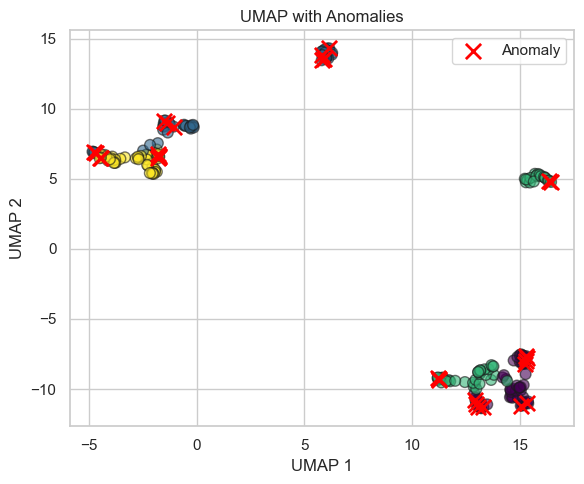

In [13]:
# Choose contamination level for anomalies
contamination = 0.15
anomaly_labels = anomaly_results[contamination]["labels"]
anomaly_mask = anomaly_labels == -1

# PCA with anomalies
plt.figure(figsize=(6, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1],
            c=df_copy['cluster'], cmap='viridis', s=80, alpha=0.6, edgecolors='k')
plt.scatter(features_pca[anomaly_mask, 0], features_pca[anomaly_mask, 1],
            c='red', s=120, marker='x', linewidths=2, label='Anomaly')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE with anomalies
plt.figure(figsize=(6, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
            c=df_copy['cluster'], cmap='viridis', s=80, alpha=0.6, edgecolors='k')
plt.scatter(features_tsne[anomaly_mask, 0], features_tsne[anomaly_mask, 1],
            c='red', s=120, marker='x', linewidths=2, label='Anomaly')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

# UMAP with anomalies
plt.figure(figsize=(6, 5))
plt.scatter(features_umap[:, 0], features_umap[:, 1],
            c=df_copy['cluster'], cmap='viridis', s=60, alpha=0.6, edgecolors='k')
plt.scatter(features_umap[anomaly_mask, 0], features_umap[anomaly_mask, 1],
            c='red', s=120, marker='x', linewidths=2, label='Anomaly')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

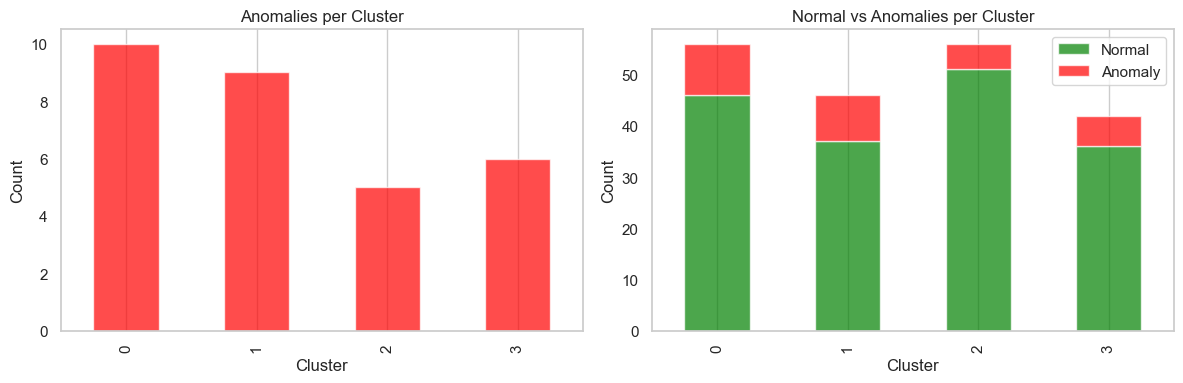

Anomalies per cluster:
cluster
0    10
1     9
2     5
3     6
dtype: int64

Normal points per cluster:
cluster
0    46
1    37
2    51
3    36
dtype: int64


In [14]:
# Plot anomaly counts per cluster
anomaly_counts = df_copy[anomaly_mask].groupby('cluster').size()
normal_counts = df_copy[~anomaly_mask].groupby('cluster').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart of anomaly counts per cluster
anomaly_counts.plot(kind='bar', ax=axes[0], color='red', alpha=0.7)
axes[0].set_title('Anomalies per Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')

# Stacked bar chart of normal vs anomalies per cluster
cluster_distribution = pd.DataFrame({
    'Normal': normal_counts,
    'Anomaly': anomaly_counts
}).fillna(0)
cluster_distribution.plot(kind='bar', stacked=True, ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Normal vs Anomalies per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].legend(['Normal', 'Anomaly'])
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

print("Anomalies per cluster:")
print(anomaly_counts)
print("\nNormal points per cluster:")
print(normal_counts)

In [15]:
# Display anomalous datapoints
anomalous_data = df_copy[anomaly_mask][['age', 'annual_income_k$', 'spending_score_1-100', 'gender', 'cluster']].head(10)
print("Sample of anomalous datapoints:")
print(anomalous_data)

# Show summary statistics of anomalies vs normal points
print("\nComparison of anomalies vs normal points:")
print("\nAnomalies:")
print(df_copy[anomaly_mask][['age', 'annual_income_k$', 'spending_score_1-100']].describe())
print("\nNormal points:")
print(df_copy[~anomaly_mask][['age', 'annual_income_k$', 'spending_score_1-100']].describe())

Sample of anomalous datapoints:
    age  annual_income_k$  spending_score_1-100  gender  cluster
0    19                15                    39       1        1
1    21                15                    81       1        1
2    20                16                     6       0        0
6    35                18                     6       0        0
7    23                18                    94       0        2
8    64                19                     3       1        3
10   67                19                    14       1        3
11   35                19                    99       0        2
12   58                20                    15       0        0
19   35                23                    98       0        2

Comparison of anomalies vs normal points:

Anomalies:
             age  annual_income_k$  spending_score_1-100
count  30.000000         30.000000             30.000000
mean   39.966667         63.066667             42.600000
std    16.080580         45